# 2020年 LTトーク　ベイズ手法によるハイパーパラメータ最適化　

目的：
* GPyOPt ライブラリの紹介。
* ベイジアン最適化の紹介。


ベイジアン最適化についてお勧めの著書

https://www.amazon.co.jp/%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E3%81%A8%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%8C%81%E6%A9%8B-%E5%A4%A7%E5%9C%B0/dp/4061529269

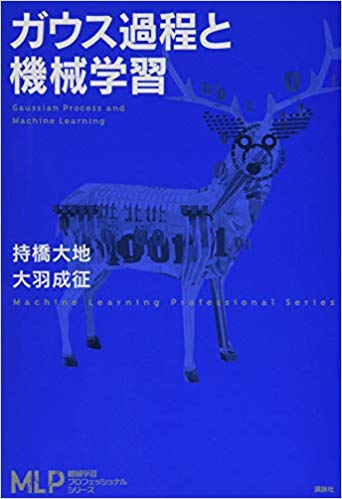


かなり良いドキュメントがあるので是非参考にして下さい。良い資料が多いので勉強会のなどの必要性が低い。

https://sheffieldml.github.io/GPyOpt/

https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/devel/manual/GPyOpt_reference_manual.ipynb


# ベイズ最適化とはなに？ (Bayesian Optimization)


* ブラックボックス関数の最適化。
* 比較的弱い仮定のもとでの最適化：似ている入力は似ている
* 代理関数を用いて未知の入力のパフォーマンスの可能性を推定する。
* この場合の代理関数は**ガウス過程**。
* 学習コストが高いモデルのハイパーパラメータチューニングに適している。

# 最適化の比較

よくニューラルネットのハイパーパラメータチューニングに使われる手法。
* ランダムサーチ
* ベイジアン最適化

source: http://krasserm.github.io/2018/03/21/bayesian-optimization/

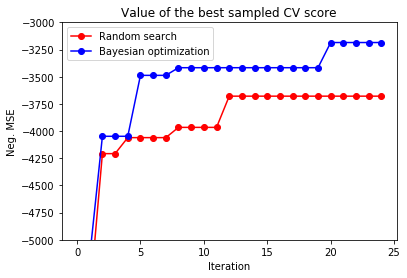

### ランダムサーチ
学習が速いモデルに適している。

利点：
* 並列処理が容易

欠点：
* 一般的に高次元パラメータ調整で精度を出すには非常に多けくのデータサンプルが必須。つまり、収束が遅い。

### ベイジアン最適化（ガウス過程）
学習が遅いモデルに適している。

利点：
* 高次元パラメータ調整でも比較的少ないデータサンプル数でも高精度が期待できる。

欠点：
* 各評価の計算コストが高い。ガウス過程の計算複雑性は$O(n^3)$
* 並列処理が比較的難しい。

ガウス過程の計算コストは高いので、モデル構築が速い場合にはボトルネックとなる。モデル構築速度が遅い深層学習に適している。計算が速いモデルには他の手法を用いた方が良い。

# インストレーション

!pip install GPyOpt

# 実装例

In [96]:
import GPy
import GPyOpt

In [97]:
from numpy.random import seed
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 最適化が容易な関数

GPyOptではデフォルトで関数の最小化を行う。オプションで最大化に切り替えることができるかは、今のところ分からない。最大化問題を解くには評価値にマイナスをかければよい。

In [104]:
def myf(x):
    return 4*(x**2)+10

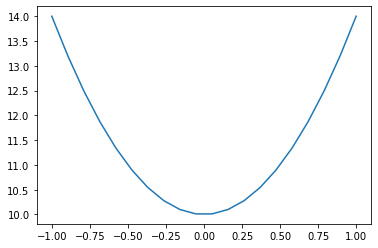

In [105]:
x = np.linspace(-1,1,20)
plt.plot(x,myf(x))
plt.show()

In [106]:
# 検索範囲を指定。
# 離散変数も指定できる。離散変数は連続変数の後に定義する。
'''
例：
bounds = [{'name':'var_1', 'type':'continuous', 'domain':(-1,1)},
          {'name':'var_2', 'type':'continuous', 'domain':(-100,100)},
          {'name':'var_3', 'type':'discrete', 'domain':(-10,10)},
         ]
'''

bounds = [{'name':'var_1', 'type':'continuous', 'domain':(-1,1)}]

In [107]:
max_iter = 15

In [116]:
myProblem = GPyOpt.methods.BayesianOptimization(myf,
                                                bounds,
                                                acquisition_type='EI',
                                                exact_feval = True
                                               )

In [117]:
import time
start = time.time()
def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return '%02d:%02d:%02d' % (hours, mins, secs)

myProblem.run_optimization(max_iter)
print( 'runtime: {}'.format( humanize_time(time.time() - start)  ))

runtime: 00:00:06


In [118]:
# 最適な変数
myProblem.x_opt

array([0.00015359])

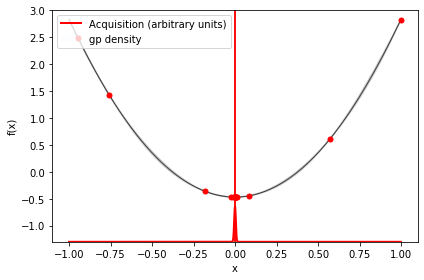

In [119]:
myProblem.plot_acquisition()

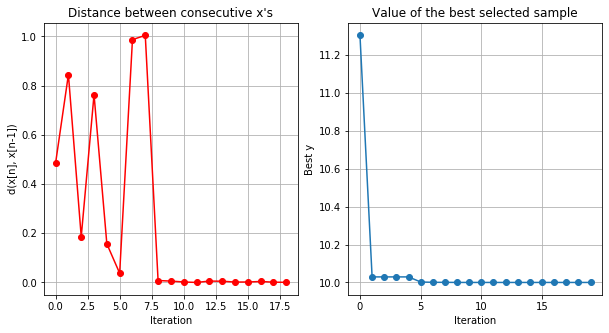

In [120]:
myProblem.plot_convergence()

## より複雑な関数の例

In [121]:
f_true= GPyOpt.objective_examples.experiments1d.forrester()          # noisy version
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]  # problem constraints 

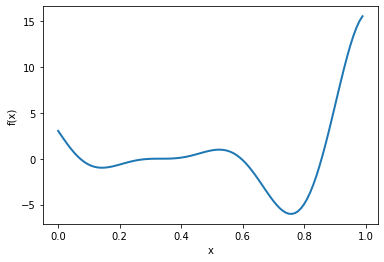

In [122]:
f_true.plot()

### 獲得関数、期待改善度(Expected Improvements)による最適化

In [144]:
# initial_design_numdataは最初に取得するサンプル数。

myBopt = GPyOpt.methods.BayesianOptimization(f=f_true.f,            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             initial_design_numdata=5,
                                             exact_feval = True) # Selects the Expected improvement

In [145]:
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

start = time.time()
myBopt.run_optimization(max_iter, max_time, eps)
print( 'runtime: {}'.format( humanize_time(time.time() - start)  ))

runtime: 00:00:03


In [146]:
myBopt.x_opt

array([0.75744868])

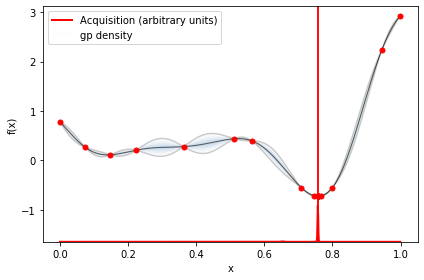

In [147]:
myBopt.plot_acquisition()

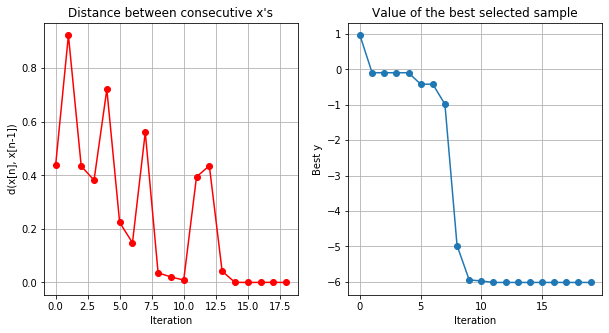

In [148]:
myBopt.plot_convergence()

### 獲得関数、信頼性低限(Lower Confidence Bound)による最適化

In [152]:
myBopt = GPyOpt.methods.BayesianOptimization(f=f_true.f,            # function to optimize       
                                             domain=bounds,         # box-constraints of the problem
                                             initial_design_numdata=5,
                                             acquisition_type='LCB') 

The set cost function is ignored! LCB acquisition does not make sense with cost.


In [153]:
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

start = time.time()
myBopt.run_optimization(max_iter, max_time, eps)
print( 'runtime: {}'.format( humanize_time(time.time() - start)  ))

runtime: 00:00:04


In [154]:
myBopt.x_opt

array([0.75729498])

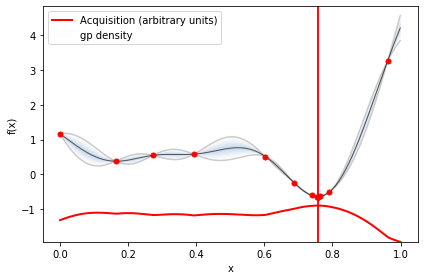

In [155]:
myBopt.plot_acquisition()

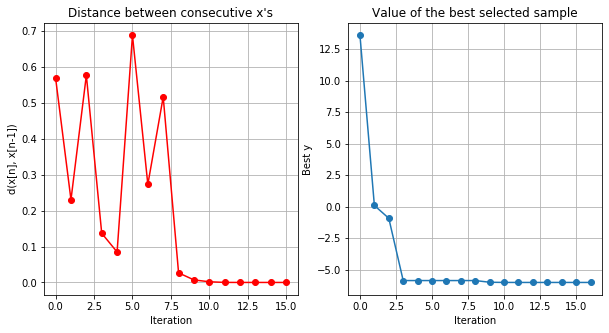

In [156]:
myBopt.plot_convergence()

# 多数のGPUでの実装

GPyOptPのバッチ化機能を用いて多数のGPUでの実装。下記を参考に外部から次の入力値を推定する。

外部から目的関数を評価する方法：  

https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_external_objective_evaluation.ipynb

大まかな仕組み：

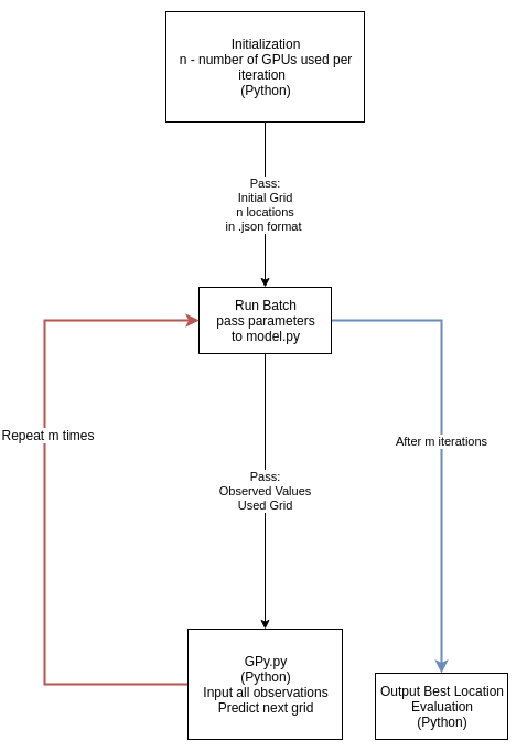

細かくは：

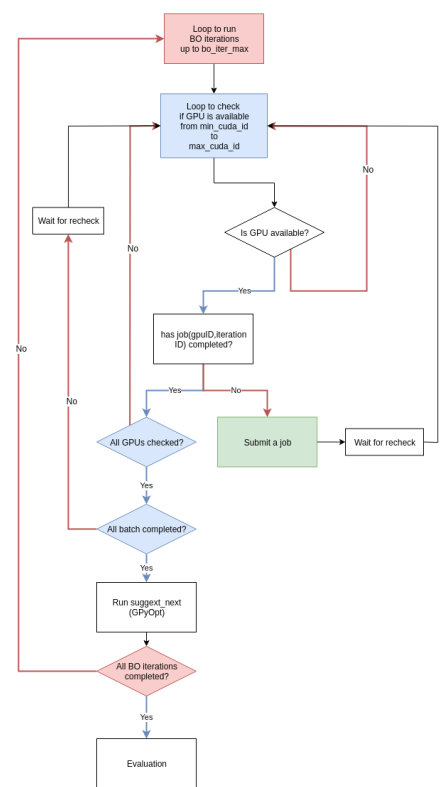

深層学習の主なハイパーパラメータ:

1. 学習レート（Rectify Adamによって、それほどチューニングの必要性が低くなったかも）
2. ニューロン数 (多いと過学習しやすいと言われるが、Double Descentなどの現象からも理解が見直されてくかも)
3. コスト関数　（Multi-task Lossの重みの調整など）
4. 活性化関数

実験：現在GANomalyというネットワークのコスト関数のチューニングを行っている。１０イテレーションくらいでは、あまり良い結果は出ていなかった。今後良い結果が出たら報告する。
結果が良くない理由と思われるもの：
* モデル精度の再現性が低い。
* 近傍の評価の相関性が低い。
* カーネルが適切でない。

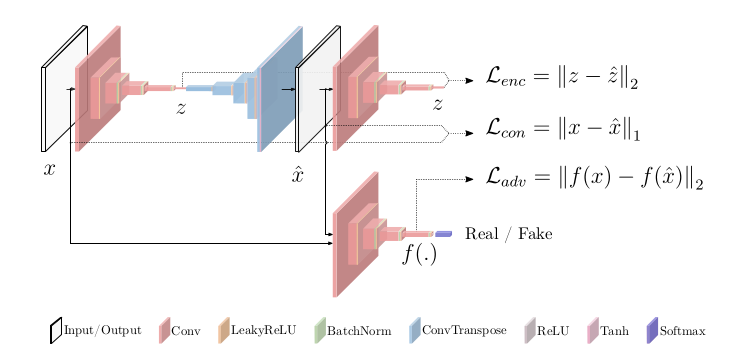

https://arxiv.org/abs/1805.06725

課題：
* いくつかのネットワークで試す。
* カーネルの最適化。
